In [1]:
from opty import Problem, create_objective_function, parse_free
import sympy as sp
import numpy as np
import time as ts
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "..")
from importlib import reload
import optyEngine as oe
reload (oe);

In [2]:
### BY JASON MOORE ###
# just different way how create equations of motion,
# here one more speed is introduced, but this approach has a singularity when q0=0

import sympy.physics.mechanics as me
import sympy as sp

t = sp.symbols('t')
q0A, q1A, q2A, q3A, q0B, q1B, q2B, q3B = me.dynamicsymbols('q0A, q1A, q2A, q3A, q0B, q1B, q2B, q3B')  # quaternion
w1A, w2A, w3A, w1B, w2B, w3B = me.dynamicsymbols('w1A, w2A, w3A, w1B, w2B, w3B')  # angular velocities
u0A, u0B = me.dynamicsymbols('u0A u0B')
l = 5
m = 10
g = 9.81
Ixx = 10
Iyy = 1
Izz = 5
F = me.dynamicsymbols('F1:7')


N = me.ReferenceFrame('frame_ground')
N0 = me.Point('point_ground')
N0.set_vel(N,0)

A = me.ReferenceFrame('A')
B = me.ReferenceFrame('B')
mA = me.Point('mA')
mB = me.Point('mB')
ABj = me.Point('ABj')


A.orient(N, 'Quaternion', [q0A, q1A, q2A, q3A])

N_w_A = A.ang_vel_in(N)
 
kinematical1 = sp.Matrix([
    u0A - q0A.diff(t),
    w1A - N_w_A.dot(A.x),
    w2A - N_w_A.dot(A.y),
    w3A - N_w_A.dot(A.z),
])

B.orient(A, 'Quaternion', [q0B, q1B, q2B, q3B])

A_w_B = B.ang_vel_in(A)

kinematical2 = (sp.Matrix([
    u0B - q0B.diff(t),
    w1B - A_w_B.dot(B.x),
    w2B - A_w_B.dot(B.y),
    w3B - A_w_B.dot(B.z),
]))

A.set_ang_vel(N, w1A*A.x + w2A*A.y + w3A*A.z)
B.set_ang_vel(A, w1B*B.x + w2B*B.y + w3B*B.z)

mA.set_pos(N0, -l/2 * A.z)
mA.v2pt_theory(N0,N,A)
FG1 = [(mA, -m * g * N.z)]

ABj.set_pos(N0, -l * A.z)
ABj.v2pt_theory(N0,N,A)


mB.set_pos(ABj, -l/2 * B.z)
mB.v2pt_theory(ABj,N,B)


I1 = me.inertia(A, Ixx, Iyy, Izz)
I2 = me.inertia(B, Ixx, Iyy, Izz)

BODY = []
BODY.append(me.RigidBody('Abody', mA, A, m, (I1, mA)))
BODY.append(me.RigidBody('Bbody', mB, B, m, (I2, mB)))

kinematical = sp.Matrix([[kinematical1],[kinematical2]])

FG2 = [(mB, -m * g * N.z)]
Torque1 = [(A, 1000*(F[0]*A.x+F[1]*A.y+F[2]*A.z))]
Torque2 = [(B, 1000*(F[3]*B.x+F[4]*B.y+F[5]*B.z))]
k = sp.Piecewise((q0A * q0A, q0A >= 0.8),(0, q0A < 0.8))
Torque3 = [(A, 100*(A.x+A.y+A.z))]

holonomic = sp.Matrix([[q0A**2 + q1A**2 + q2A**2 + q3A**2 - 1],
                       [q0B**2 + q1B**2 + q2B**2 + q3B**2 - 1]])
kane = me.KanesMethod(
    N,
    [q1A, q2A, q3A, q1B, q2B, q3B],
    [w1A, w2A, w3A, w1B, w2B, w3B],
    kd_eqs=kinematical,
    q_dependent=[q0A,q0B],
    u_dependent=[u0A,u0B],
    configuration_constraints=holonomic,
    velocity_constraints=holonomic.diff(t),
)
(fr, frstar) = kane.kanes_equations(BODY, (FG1+FG2+Torque1+Torque2+Torque3))

In [3]:
kane.u

Matrix([
[w1A(t)],
[w2A(t)],
[w3A(t)],
[w1B(t)],
[w2B(t)],
[w3B(t)],
[u0A(t)],
[u0B(t)]])

In [4]:
eoms = sp.Matrix(kinematical).col_join(fr+frstar).col_join(holonomic)

In [5]:
me.mprint(B.ang_vel_in(A))

w1B*B.x + w2B*B.y + w3B*B.z


In [6]:
kane.u

Matrix([
[w1A(t)],
[w2A(t)],
[w3A(t)],
[w1B(t)],
[w2B(t)],
[w3B(t)],
[u0A(t)],
[u0B(t)]])

In [7]:
duration = 2 # seconds
num_nodes = 101
interval_value = duration/(num_nodes - 1)
time = np.linspace(0.0, duration, num=num_nodes)

state_symbols = (q0A, q1A, q2A, q3A, q0B, q1B, q2B, q3B, w1A, w2A, w3A, w1B, w2B, w3B, u0A, u0B)
num_states = len(state_symbols)
specified_symbols = tuple(F)
num_inputs = len(specified_symbols)
t = me.dynamicsymbols._t

In [8]:
import optyEngine as oe
reload (oe);
eul,deul = oe.create_trajectory(num_nodes,duration,interval_value)
_,_,quat_traj,quat_traj_guess= oe.eul2quat_traj(num_nodes,eul,interval_value)

In [9]:
def obj(free):
    min_traj = interval_value * np.sum((quat_traj_guess[:4*2*num_nodes] - free[:4*2*num_nodes])**2)
    min_torque = 0.00005 * interval_value * np.sum(free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
    return min_traj + min_torque

def obj_grad(free):
    grad = np.zeros_like(free)
    grad[:4*2*num_nodes] = 2.0 * interval_value * (free[:4*2*num_nodes] - quat_traj_guess[:4*2*num_nodes])
    grad[num_states*num_nodes:(num_states + num_inputs)*num_nodes] = 0.00005 * 2.0 * interval_value * free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]
    return grad

In [10]:
instance_constraints = (
    q0A.func(0.0) - 1,
    q1A.func(0.0) - 0,
    q2A.func(0.0) - 0,
    q3A.func(0.0) - 0,
    q0B.func(0.0) - 1,
    q1B.func(0.0) - 0,
    q2B.func(0.0) - 0,
    q3B.func(0.0) - 0,
    w1A.func(0.0) - 0,
    w2A.func(0.0) - 0,
    w3A.func(0.0) - 0,
    w1B.func(0.0) - 0,
    w2B.func(0.0) - 0,
    w3B.func(0.0) - 0,
    u0A.func(0.0) - 0,
    u0B.func(0.0) - 0,
)

max_force = 50000.0
bounds = {
    F[0]: (-max_force, max_force),
    F[1]: (-max_force, max_force),
    F[2]: (-max_force, max_force),
    F[3]: (-max_force, max_force),
    F[4]: (-max_force, max_force),
    F[5]: (-max_force, max_force),
}

In [11]:
start = ts.time()

prob = Problem(obj, obj_grad, eoms, state_symbols,
               num_nodes, interval_value,
               known_parameter_map={},
               instance_constraints=instance_constraints,
               bounds=bounds,
               integration_method='midpoint')

# prob.add_option('nlp_scaling_method', 'gradient-based')

time_to_create = ts.time() - start
print(time_to_create)


22.430294513702393


In [12]:
initial_guess = np.random.randn(prob.num_free)*0
initial_guess[:8*2*num_nodes] = quat_traj_guess
prob.add_option('max_iter',15000)
# prob.add_option('acceptable_tol', 1e-1)
# prob.add_option('tol', 1e-1)

In [13]:
start = ts.time()

solution, info = prob.solve(initial_guess)

time_to_create = ts.time() - start
print(time_to_create)
print(info['status_msg'])
print(info['obj_val'])

15.00995922088623
b'Algorithm stopped at a point that was converged, not to "desired" tolerances, but to "acceptable" tolerances (see the acceptable-... options).'
4.9850990330523586e-05


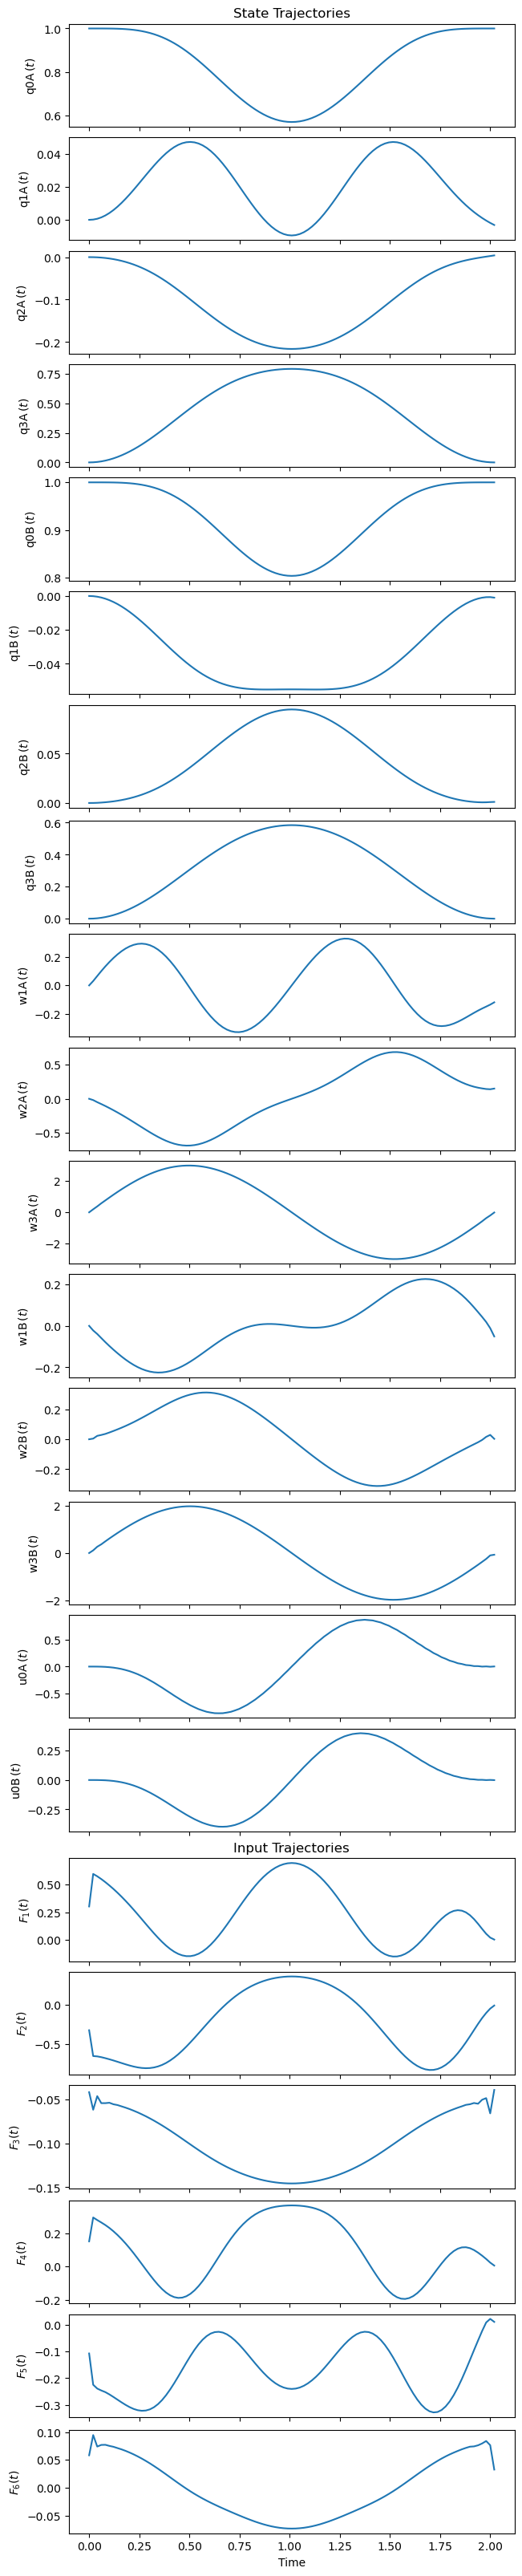

In [14]:
fig, axes = plt.subplots(22, 1, sharex=True,
                         figsize=(6.4, 0.8*40),
                         layout='compressed')
prob.plot_trajectories(solution, axes=axes)

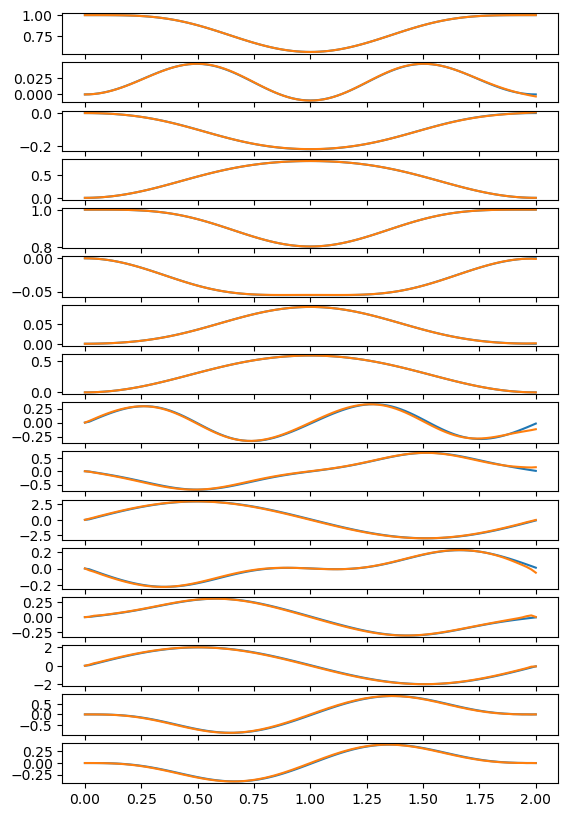

In [15]:
fig, axs = plt.subplots(16)
for j in range(16):
    axs[j].plot(time,quat_traj_guess[j*num_nodes:(j+1)*num_nodes])
    axs[j].plot(time,solution[j*num_nodes:(j+1)*num_nodes])
    fig.set_figheight(10)

In [16]:
# num_nodes_new = 101
# interval_value_new = duration/(num_nodes_new - 1)

# num_vars = len(state_symbols)+len(specified_symbols)
# initial_new = oe.interpolate_results(num_nodes, solution, num_vars, num_nodes_new, time)
# eul,deul = oe.create_trajectory(num_nodes,duration,interval_value_new)
# quat_traj,quat_traj_guess,_,_ = oe.eul2quat_traj(num_nodes,eul_traj,interval_value)

# def obj_new(free):
#     min_obj = interval_value_new * np.sum((quat_traj_new - free[:4*2*num_nodes])**2)
#     return min_obj

# def obj_grad_new(free):
#     grad = np.zeros_like(free)
#     grad[:8*2*num_nodes] = 2.0 * interval_value_new * (free[:8*2*num_nodes] - quat_traj_new)
#     return grad

# prob_new = Problem(obj_new, obj_grad_new, eoms, state_symbols,
#                num_nodes_new, interval_value_new,
#                known_parameter_map={},
#                instance_constraints=instance_constraints,
#                bounds={})

# prob_new.add_option('nlp_scaling_method', 'gradient-based')
# prob_new.add_option('max_iter',1000000)
# print('Done')

# start = ts.time()

# solution_new, info_new = prob_new.solve(initial_new)

# time_to_create = ts.time() - start
# print(time_to_create)
# print(info['status_msg'])
# print(info['obj_val'])

# fig, axes = plt.subplots(22, 1, sharex=True,
#                          figsize=(6.4, 0.8*18),
#                          layout='compressed')
# prob_new.plot_trajectories(solution_new, axes=axes)